<center><h1>Food Demand Forecasting<h1><center>

<img src='https://datahack-prod.s3.ap-south-1.amazonaws.com/__sized__/contest_cover/food_1920x480_9XIpdm8-thumbnail-1200x1200-90.jpg'/>

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

Historical data of demand for a product-center combination (Weeks: 1 to 145)
Product(Meal) features such as category, sub-category, current price and discount
Information for fulfillment center like center area, city information etc.

### Data Dictionary
 

- Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable


<img src='img/Screenshot_1.png'/>

- fulfilment_center_info.csv: Contains information for each fulfilment center

<img src='img/Screenshot_2.png' width='300'/>

- meal_info.csv: Contains information for each meal being served

<img src='img/Screenshot_3.png'/>

### Import important Library

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# import pandas_profiling as pp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import mean_squared_error
# from catboost import CatBoostRegressor
# from catboost import Pool

from pandasql import sqldf
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
plt.rcParams['agg.path.chunksize'] = 10000
from statsmodels.graphics.api import qqplot

In [2]:
sql=lambda x: sqldf(x,globals())

In [19]:
sqldf("select * from df",globals())

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
5,1270037,1,55,1248,251.23,252.23,0,0,28
6,1191377,1,55,1778,183.36,184.36,0,0,190
7,1499955,1,55,1062,182.36,183.36,0,0,391
8,1025244,1,55,2707,193.06,192.06,0,0,472
9,1054194,1,55,1207,325.92,384.18,0,1,676


In [3]:
df=pd.read_csv("train.csv")
train=pd.read_csv("train.csv")
# test = pd.read_csv('test.csv')
fulfilment_center=pd.read_csv('fulfilment_center_info.csv')
meal_info=pd.read_csv('meal_info.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


In [7]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [8]:
train.shape

(456548, 9)

In [9]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [10]:
fulfilment_center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


### Merge Using Python

In [13]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0
1,1127204,146,55,1993,160.11,159.11,0,0,647,56,TYPE_C,2.0
2,1212707,146,55,2539,157.14,159.14,0,0,647,56,TYPE_C,2.0
3,1082698,146,55,2631,162.02,162.02,0,0,647,56,TYPE_C,2.0
4,1400926,146,55,1248,163.93,163.93,0,0,647,56,TYPE_C,2.0


In [14]:
train = pd.merge(train,fulfilment_center, on='center_id')
# test = pd.merge(test,fulfilment_center, on='center_id')

train = pd.merge(train,meal_info, on='meal_id')
# test = pd.merge(test,meal_info, on='meal_id')

In [15]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [11]:
sql(''' select * from train
        where week=1

''')

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1040403,1,24,1885,136.83,136.83,0,0,1498,614,85,TYPE_B,3.6,Beverages,Thai
2,1103215,1,11,1885,136.83,136.83,0,0,959,679,56,TYPE_A,3.7,Beverages,Thai
3,1034383,1,83,1885,121.31,120.31,0,1,1025,659,77,TYPE_A,5.3,Beverages,Thai
4,1118999,1,32,1885,114.52,113.52,0,1,445,526,34,TYPE_A,3.8,Beverages,Thai
5,1171094,1,13,1885,135.86,122.28,0,1,2132,590,56,TYPE_B,6.7,Beverages,Thai
6,1472084,1,109,1885,134.86,134.86,0,0,890,599,56,TYPE_A,3.6,Beverages,Thai
7,1212128,1,52,1885,134.89,132.89,0,0,877,685,56,TYPE_B,5.6,Beverages,Thai
8,1297434,1,93,1885,116.46,116.46,0,0,580,461,34,TYPE_A,3.9,Beverages,Thai
9,1280872,1,186,1885,114.49,114.52,0,1,458,649,34,TYPE_A,3.4,Beverages,Thai


In [12]:
train_grp=train.groupby(['week']).sum()

In [15]:
train_grp.describe()

,id,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,1.450000e+02,145.000000,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,145.000000,1.450000e+02,1.450000e+02,145.000000,145.000000
mean,3.936062e+09,258518.875862,6.373843e+06,1.046090e+06,1.115100e+06,255.517241,343.827586,8.245344e+05,1.894055e+06,178257.013793,12857.619310
std,1.889014e+08,11756.799476,3.475186e+05,6.456945e+04,6.745161e+04,150.269855,94.708349,1.256703e+05,9.084978e+04,8858.786772,615.528926
min,3.481137e+09,231194.000000,5.503168e+06,9.011416e+05,9.641055e+05,0.000000,163.000000,3.800650e+05,1.676903e+06,156835.000000,11412.700000
25%,3.813782e+09,249958.000000,6.174113e+06,9.949741e+05,1.061920e+06,152.000000,274.000000,7.451930e+05,1.830624e+06,171863.000000,12417.100000
50%,4.008773e+09,262726.000000,6.515865e+06,1.058398e+06,1.137516e+06,231.000000,335.000000,8.096250e+05,1.928495e+06,181543.000000,13101.600000
75%,4.086730e+09,267502.000000,6.639791e+06,1.101326e+06,1.170282e+06,357.000000,407.000000,8.926310e+05,1.963951e+06,185136.000000,13350.900000
max,4.206285e+09,274997.000000,6.832095e+06,1.140145e+06,1.232478e+06,796.000000,571.000000,1.303457e+06,2.022062e+06,190361.000000,13700.600000


In [13]:
train_grp.head()

,id,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
week,,,,,,,,,,,
1,3645659662,238295,5777913,965809.26,1018365.32,357,414,792261,1758466,165591,11921.4
2,3614794872,235795,5734977,938092.43,1005779.20,621,514,787084,1743166,164178,11830.2
3,3615848647,237202,5723235,948560.28,1008352.05,104,316,695262,1745022,164383,11824.1
4,3613885389,236098,5722512,953833.69,1006446.90,0,292,743529,1738944,163637,11809.5
5,3571456643,237587,5661934,901141.58,1001075.16,337,466,1198675,1721065,160957,11658.5


### Join using SQL

In [17]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [18]:
sql("select * from df ")

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
5,1270037,1,55,1248,251.23,252.23,0,0,28
6,1191377,1,55,1778,183.36,184.36,0,0,190
7,1499955,1,55,1062,182.36,183.36,0,0,391
8,1025244,1,55,2707,193.06,192.06,0,0,472
9,1054194,1,55,1207,325.92,384.18,0,1,676


In [16]:
df_ful=sql('''select m1.id,m1.week,m1.center_id,m1.meal_id,m1.checkout_price,
       m1.base_price,m1.emailer_for_promotion,m1.homepage_featured,m1.num_orders,
       f1.city_code,f1.region_code,f1.center_type,f1.op_area
       from df m1 join fulfilment_center f1
       where m1.center_id=f1.center_id
       ''')

In [37]:
final_df=sql('''select m1.id,m1.week,m1.center_id,m1.meal_id,m1.checkout_price,
       m1.base_price,m1.emailer_for_promotion,m1.homepage_featured,m1.num_orders,
       m1.city_code,m1.region_code,m1.center_type,m1.op_area,m2.category,m2.cuisine
       from df_ful m1  join meal_info m2
       where m1.meal_id=m2.meal_id
       order by m1.week asc

''')

# 

In [38]:
final_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [39]:
df_forcast=sql('''select week,sum(num_orders) as num_orders
       from final_df
       group by week

''')

### Exploration

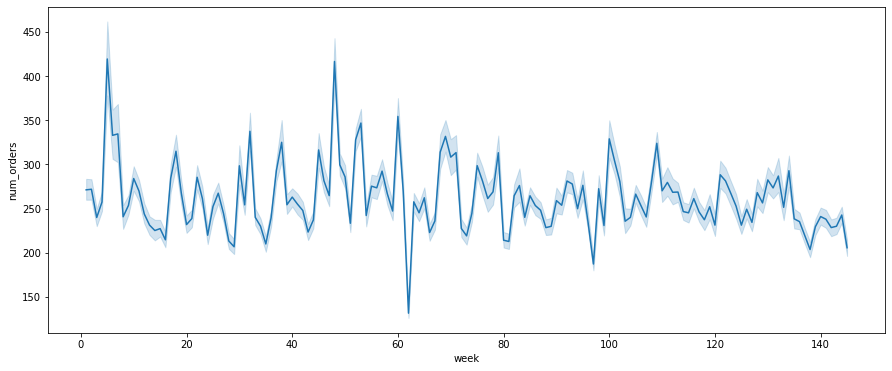

In [191]:
sns.lineplot(train['week'],train['num_orders'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 <a list of 77 Text xticklabel objects>)

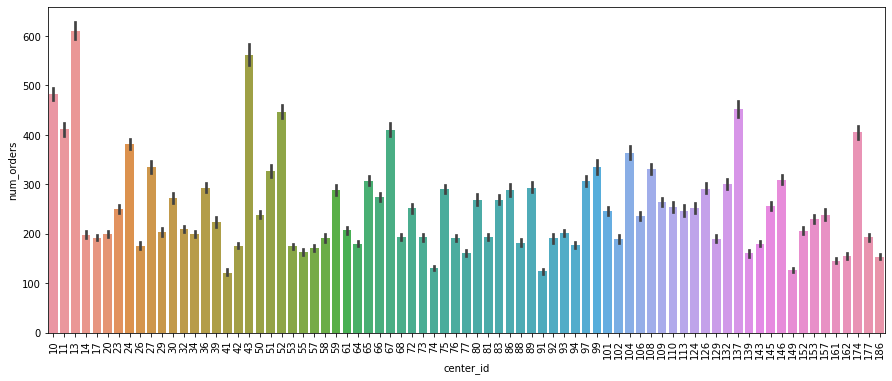

In [192]:
sns.barplot(train['center_id'],train['num_orders'])
plt.xticks(rotation=90)

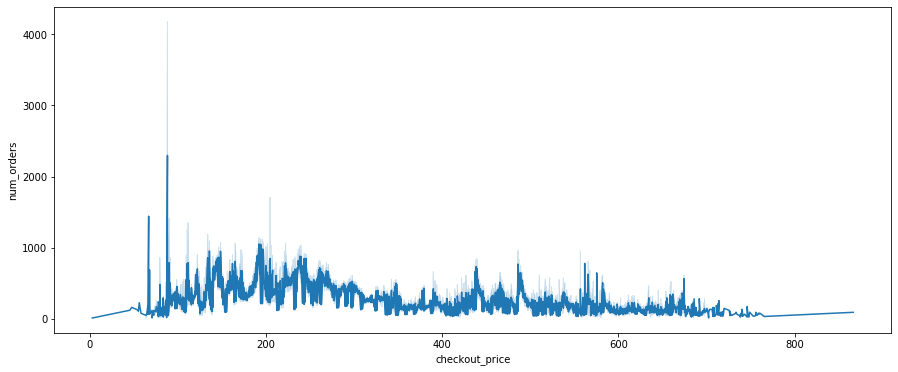

In [193]:
sns.lineplot(train['checkout_price'],train['num_orders'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

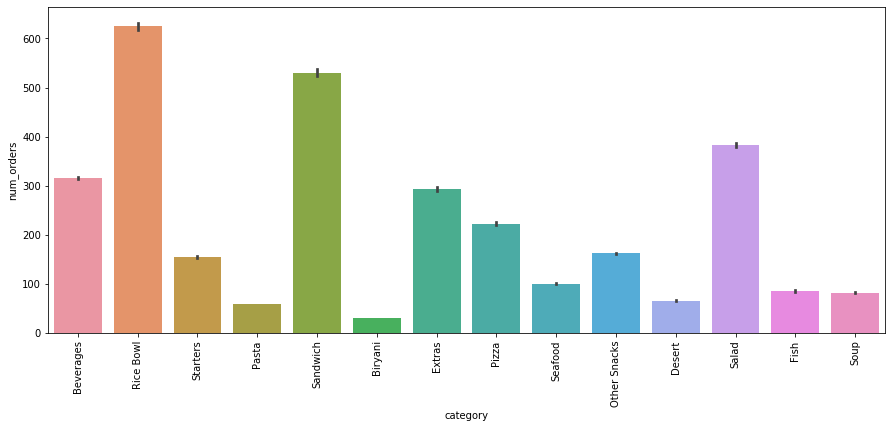

In [194]:
sns.barplot(train['category'],train['num_orders'])
plt.xticks(rotation = '90')

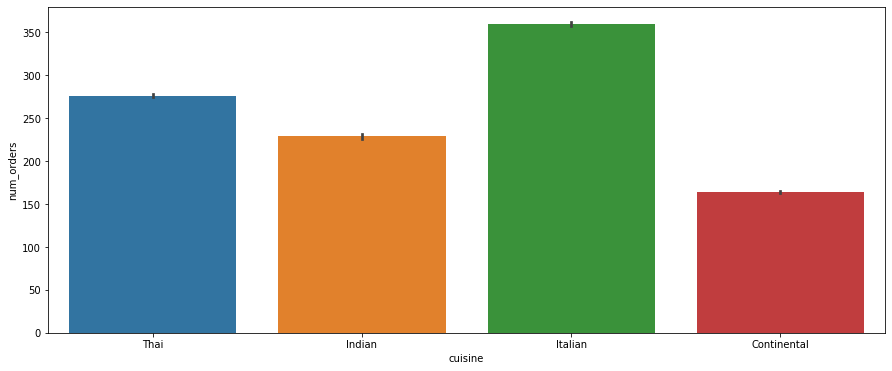

In [195]:
sns.barplot(train['cuisine'],train['num_orders'])
#plt.xticks(rotation = '90')

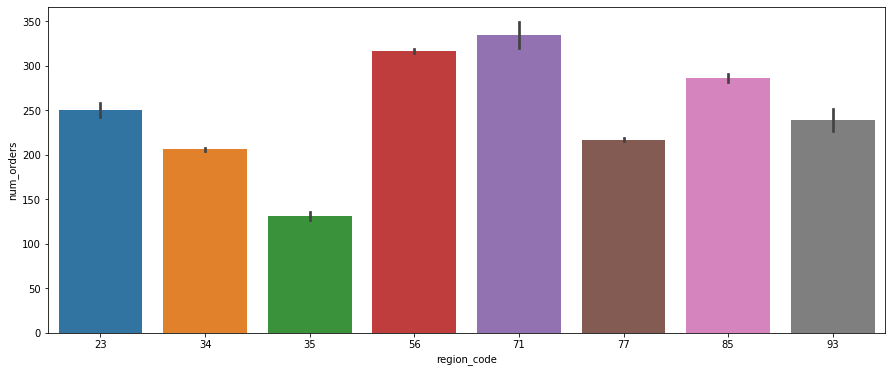

In [196]:
sns.barplot(train['region_code'],train['num_orders'])
#plt.xticks(rotation = '90')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

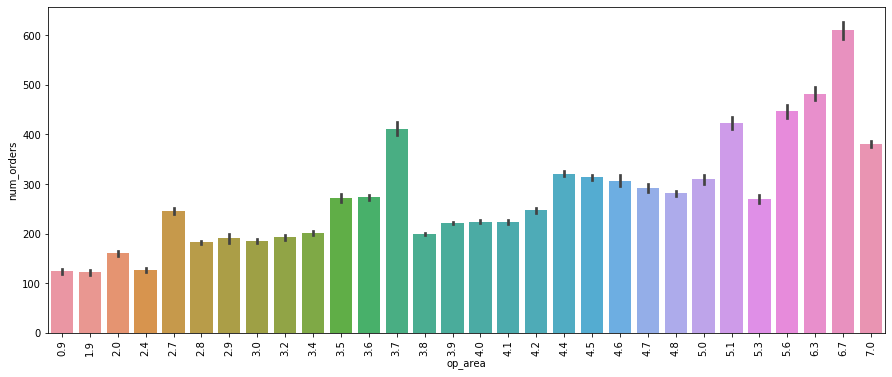

In [197]:
sns.barplot(train['op_area'],train['num_orders'])
plt.xticks(rotation = '90')

(array([400., 450., 500., 550., 600., 650., 700., 750.]),
 <a list of 8 Text xticklabel objects>)

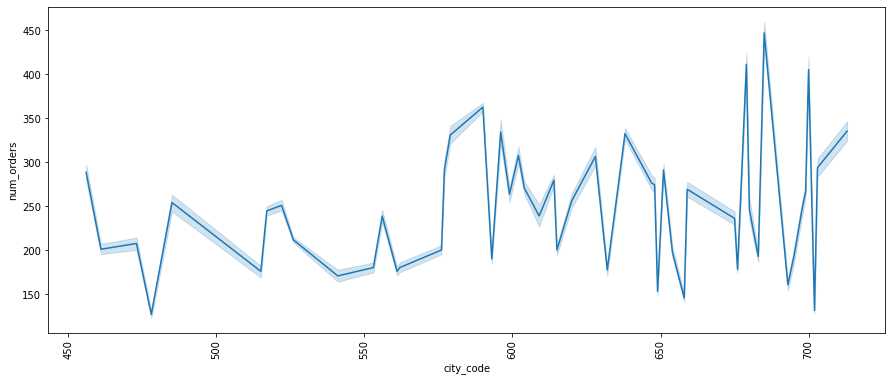

In [198]:
sns.lineplot(train['city_code'],train['num_orders'])
plt.xticks(rotation = '90')

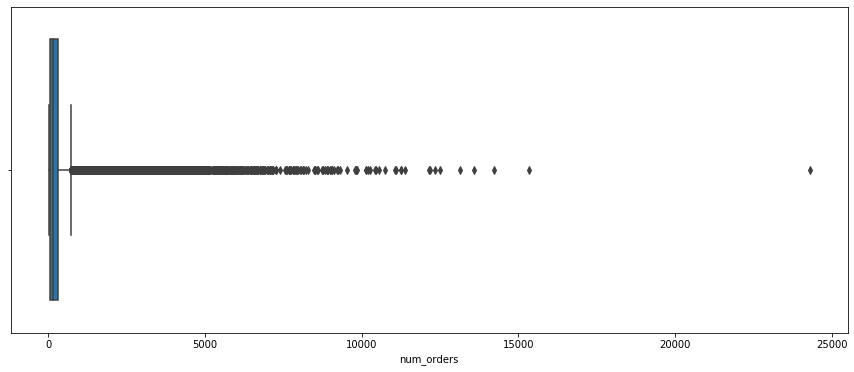

In [199]:
sns.boxplot(x='num_orders',data=train)

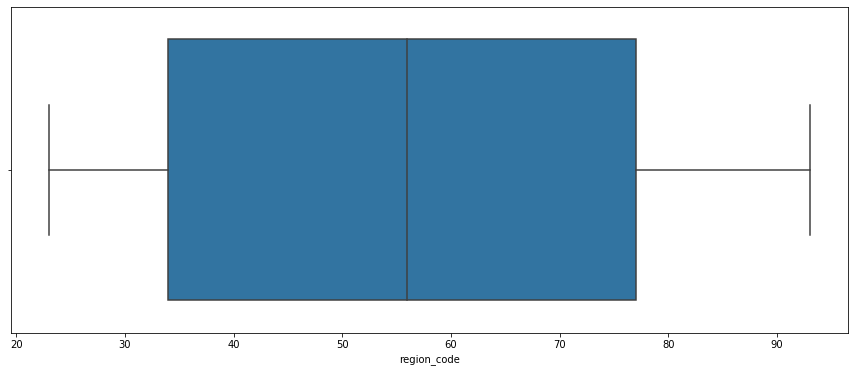

In [200]:
sns.boxplot(x='region_code',data=train)

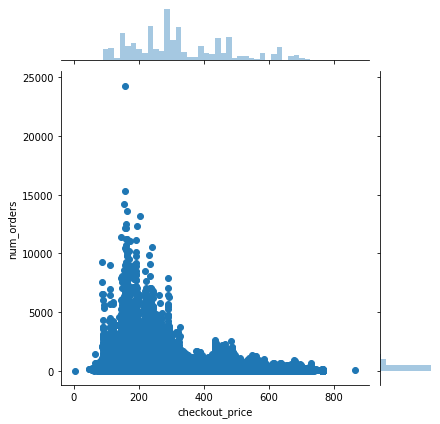

In [202]:
sns.jointplot(x='checkout_price',y='num_orders',data=train)

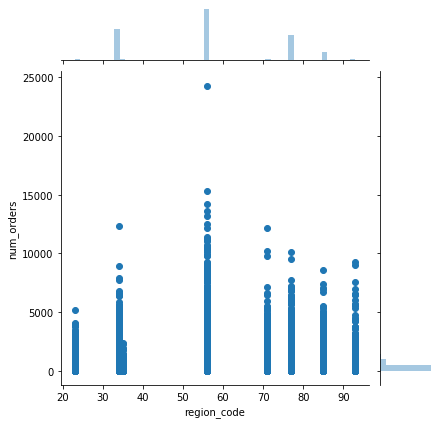

In [203]:
sns.jointplot(x='region_code',y='num_orders',data=train)

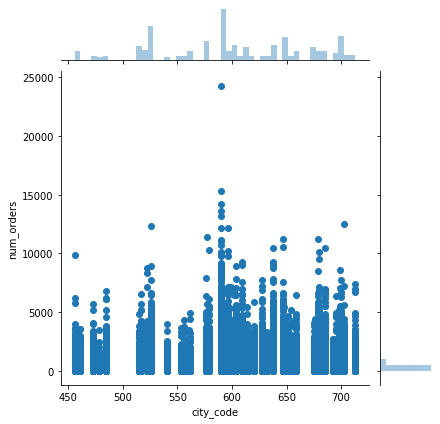

In [204]:
sns.jointplot(x='city_code',y='num_orders',data=train)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

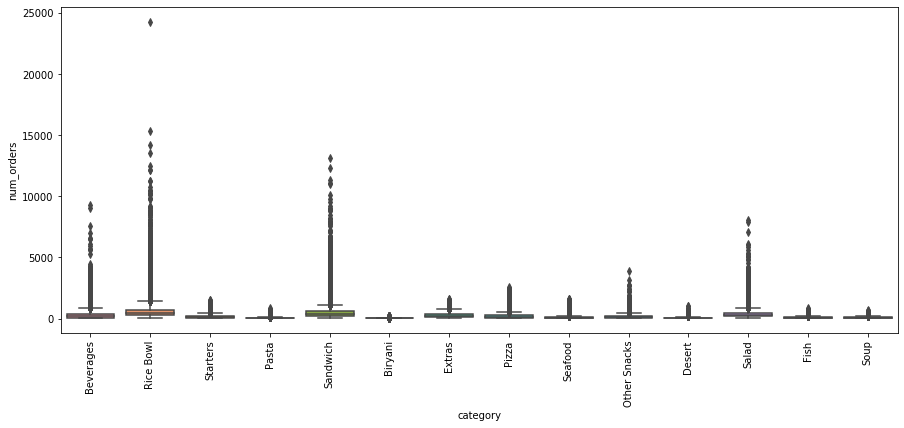

In [205]:
sns.boxplot(x='category',y='num_orders',data=train)
plt.xticks(rotation=90)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

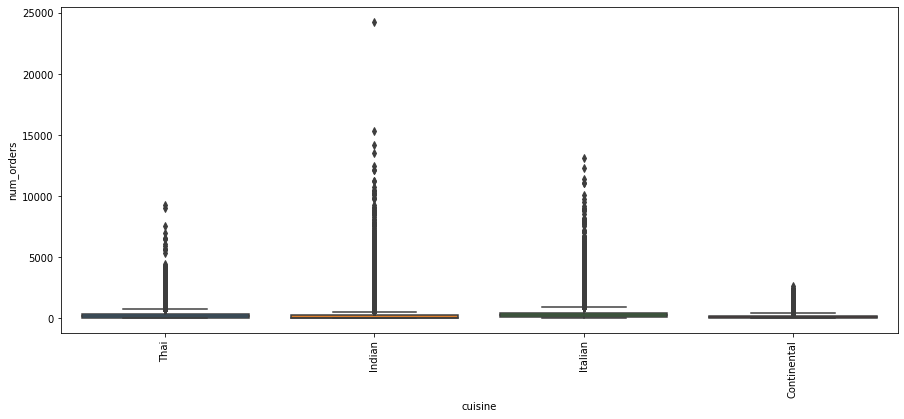

In [206]:
sns.boxplot(x='cuisine',y='num_orders',data=train)
plt.xticks(rotation=90)

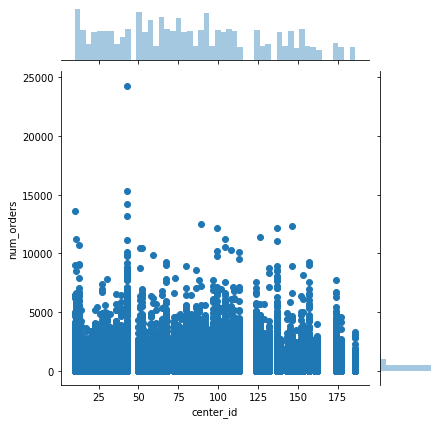

In [207]:
sns.jointplot(x='center_id',y='num_orders',data=train)

In [208]:
print("Total number of centers : ",train['center_id'].nunique())

print("Total Number of cities: ",train['city_code'].nunique())

print("Total Number of cities: ",train['city_code'].nunique())

Total number of centers :  77
Total Number of cities:  51
Total Number of cities:  51


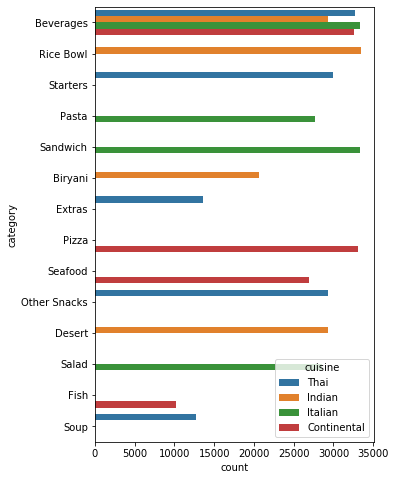

In [209]:
fig, ax = plt.subplots(figsize=(5,8))
sns.countplot(y = train['category'], hue = train['cuisine'], ax=ax)
plt.show()

In [210]:
center_meal_train = (train['center_id'].astype(str) + "_" + train['meal_id'].astype(str)).unique()
print("There are", len(center_meal_train),"center-meal pairs in train data")

center_meal_test = (test['center_id'].astype(str) + "_" + test['meal_id'].astype(str)).unique()
print("There are", len(center_meal_test),"center-meal pairs in train data")

# check if test set has any new center-mean pair or not
print("There are",len(set(center_meal_test) - set(center_meal_train)),"New center-meal pairs in test dataset which are not present in train dataset")
print(set(center_meal_test) - set(center_meal_train))

There are 3597 center-meal pairs in train data
There are 3548 center-meal pairs in train data
There are 3 New center-meal pairs in test dataset which are not present in train dataset
{'73_2956', '92_2104', '73_1571'}


In [211]:
test[(test['center_id']==73) & (test['meal_id'].isin([2956, 1571]))].shape[0]

11

In [212]:
test[(test['center_id']==92) & (test['meal_id'].isin([2104]))].shape[0]

2

### Deal with Outlier

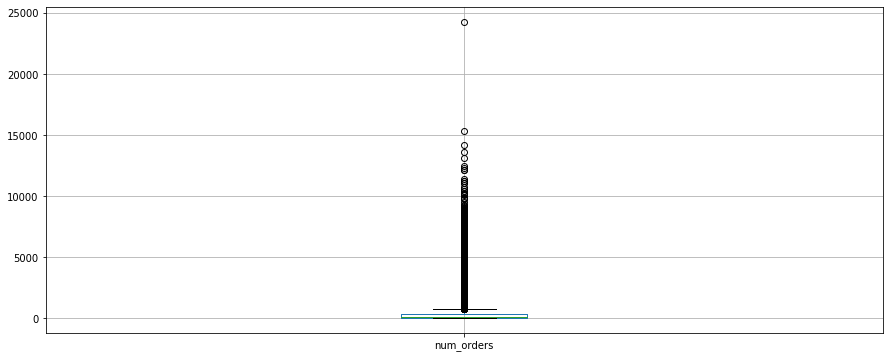

In [214]:
Boxplot=train.boxplot(column=['num_orders'])

In [262]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [30]:
# df_forcast=train[['week','num_orders']]

In [40]:
df_forcast.head()

,week,num_orders
0,1,792261
1,2,787084
2,3,695262
3,4,743529
4,5,1198675


In [41]:
df_forcast['week']=df_forcast['week'].astype(int)

In [42]:
df_forcast.head()

,week,num_orders
0,1,792261
1,2,787084
2,3,695262
3,4,743529
4,5,1198675


In [43]:
df_forcast.set_index('week',inplace=True)

In [44]:
df_forcast.head()

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675


In [45]:
df_forcast.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            136, 137, 138, 139, 140, 141, 142, 143, 144, 145],
           dtype='int64', name='week', length=145)

In [46]:
ts=df_forcast['num_orders']

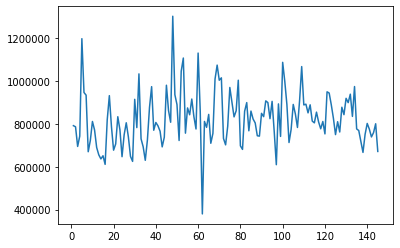

In [47]:
plt.plot(ts)

### Check Stationarity

In [48]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #determing rolling Statisics
    roll_mean=timeseries.rolling(window=12,center=False).mean()
    roll_std=timeseries.rolling(window=12,center=False).std()
    
    #plot rolliong Satatistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(roll_mean,color='red',label='Rolling Mean')
    std=plt.plot(roll_std,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    
    #perform dicky-Fuller Test:
    print("Result of Dickey-Fuller test")
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','P_value','#Lags used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Crictical value(%s)'%key]=value
    print(dfoutput)

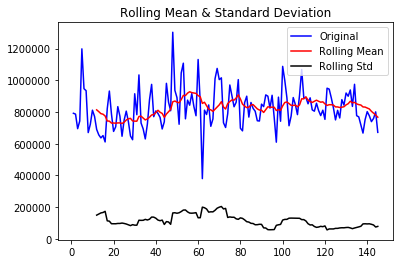

Result of Dickey-Fuller test
Test Statistics                 -2.542866
P_value                          0.105390
#Lags used                       9.000000
Number of observations used    135.000000
Crictical value(1%)             -3.479743
Crictical value(5%)             -2.883198
Crictical value(10%)            -2.578320
dtype: float64


In [49]:
test_stationarity(ts)

#### Eleminating the Trends & seasonality

##### 1.Differencing

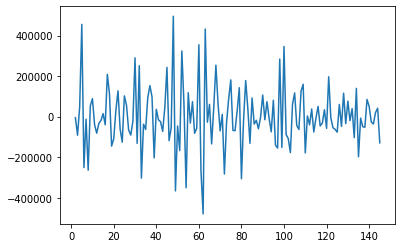

In [51]:
ts_log_diff=ts-ts.shift()
plt.plot(ts_log_diff)

In [52]:
ts_log=np.log(ts)

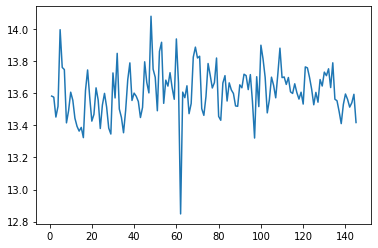

In [55]:
plt.plot(ts_log)

In [56]:
ts_log_diff=ts_log-ts_log.shift()

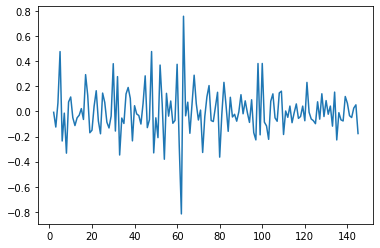

In [57]:
plt.plot(ts_log_diff)

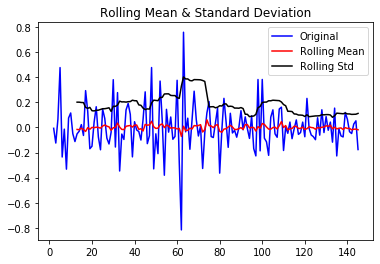

Result of Dickey-Fuller test
Test Statistics               -6.379334e+00
P_value                        2.242518e-08
#Lags used                     9.000000e+00
Number of observations used    1.340000e+02
Crictical value(1%)           -3.480119e+00
Crictical value(5%)           -2.883362e+00
Crictical value(10%)          -2.578407e+00
dtype: float64


In [58]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

##### 2.Decompose 

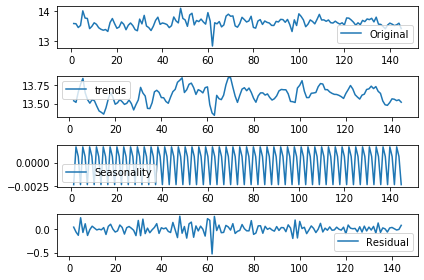

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompositions=seasonal_decompose(ts_log,freq=3)

trends=decompositions.trend
seasonal=decompositions.seasonal
residual=decompositions.resid

plt.subplot(411)
plt.plot(ts_log,label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trends,label='trends')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()

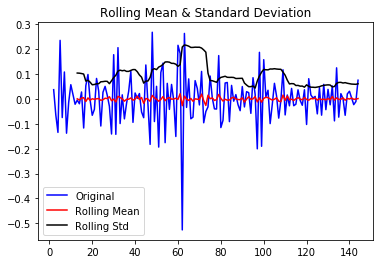

Result of Dickey-Fuller test
Test Statistics               -6.445513e+00
P_value                        1.569504e-08
#Lags used                     1.400000e+01
Number of observations used    1.280000e+02
Crictical value(1%)           -3.482501e+00
Crictical value(5%)           -2.884398e+00
Crictical value(10%)          -2.578960e+00
dtype: float64


In [60]:
ts_log_decompose=residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### Forcasting Number Of Orders

In [76]:
import statsmodels
import statsmodels.api as sm


C:\Users\kjk\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


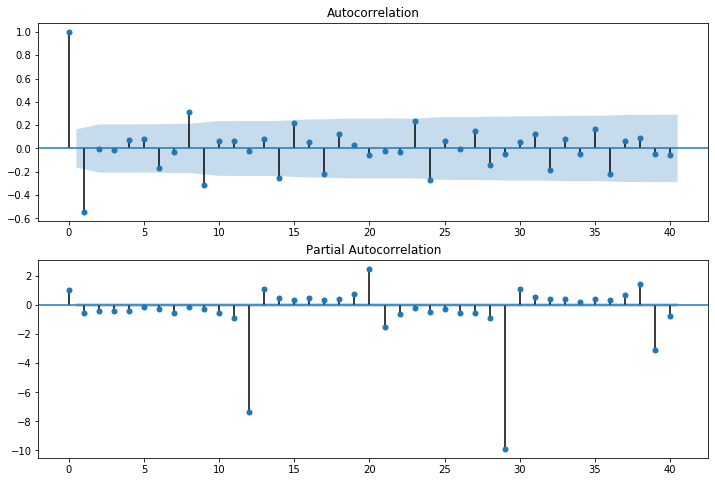

In [61]:
#find the optimal Parameter and Build the SARIMA Model
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(ts_log_decompose,lags=40,ax=ax1)

ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(ts_log_decompose,lags=40,ax=ax2)

### AutoRegressive Model

C:\Users\kjk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\kjk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


AutoRegressive Model
                             ARIMA Model Results                              
Dep. Variable:           D.num_orders   No. Observations:                  144
Model:                 ARIMA(6, 1, 0)   Log Likelihood                  66.512
Method:                       css-mle   S.D. of innovations              0.152
Date:                Thu, 04 Jun 2020   AIC                           -117.024
Time:                        12:40:06   BIC                            -93.266
Sample:                             1   HQIC                          -107.370
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0007      0.004     -0.201      0.841      -0.008       0.006
ar.L1.D.num_orders    -0.5830      0.080     -7.257      0.000      -0.741      -0.426

Text(0.5, 1.0, 'RSS: 3.3473')

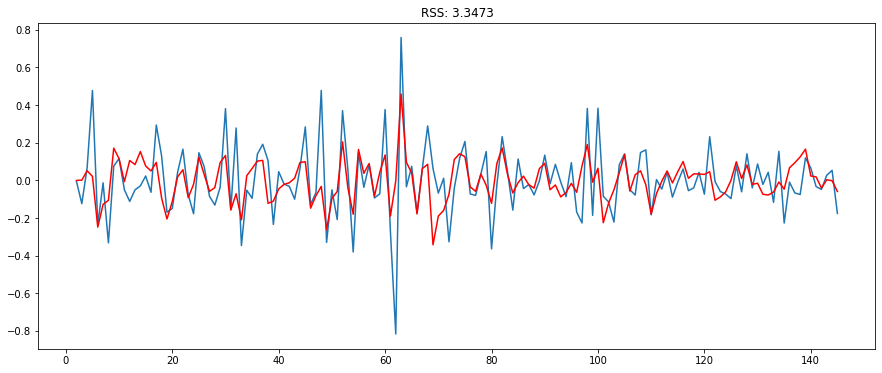

In [140]:
from statsmodels.tsa.arima_model import ARIMA
# MA Model
model=ARIMA(ts_log,order=(6,1,0))
result_AR=model.fit()
print('AutoRegressive Model')
print(result_AR.summary())
plt.plot(ts_log_diff)
plt.plot(result_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((result_AR.fittedvalues-ts_log_diff)**2))

### Moving Avarage Model

C:\Users\kjk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\kjk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Moving Avarage Model
                             ARIMA Model Results                              
Dep. Variable:           D.num_orders   No. Observations:                  144
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  63.765
Method:                       css-mle   S.D. of innovations              0.153
Date:                Thu, 04 Jun 2020   AIC                           -121.530
Time:                        12:38:46   BIC                           -112.621
Sample:                             1   HQIC                          -117.910
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0005      0.000      1.615      0.108      -0.000       0.001
ma.L1.D.num_orders    -1.0000        nan        nan        nan         nan         nan

C:\Users\kjk\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RSS: 3.4893')

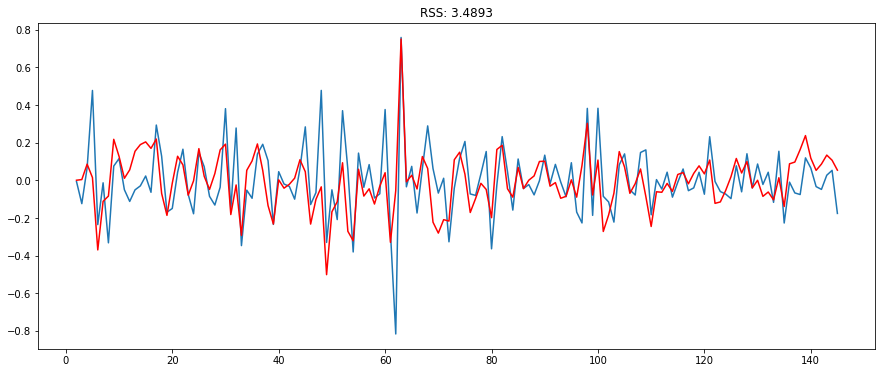

In [139]:
model=ARIMA(ts_log,order=(0,1,1))
result_MA=model.fit()
print('Moving Avarage Model')
print(result_MA.summary())
plt.plot(ts_log_diff)
plt.plot(result_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((result_MA.fittedvalues-ts_log_diff)**2))

### ARIMA Model

C:\Users\kjk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\kjk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.num_orders   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  68.535
Method:                       css-mle   S.D. of innovations              0.148
Date:                Thu, 04 Jun 2020   AIC                           -129.070
Time:                        12:37:45   BIC                           -117.191
Sample:                             1   HQIC                          -124.243
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0005      0.000      1.190      0.236      -0.000       0.001
ar.L1.D.num_orders     0.2555      0.082      3.133      0.002       0.096       0.415
ma.L1.D.num_orders  

Text(0.5, 1.0, 'RSS: 3.2667')

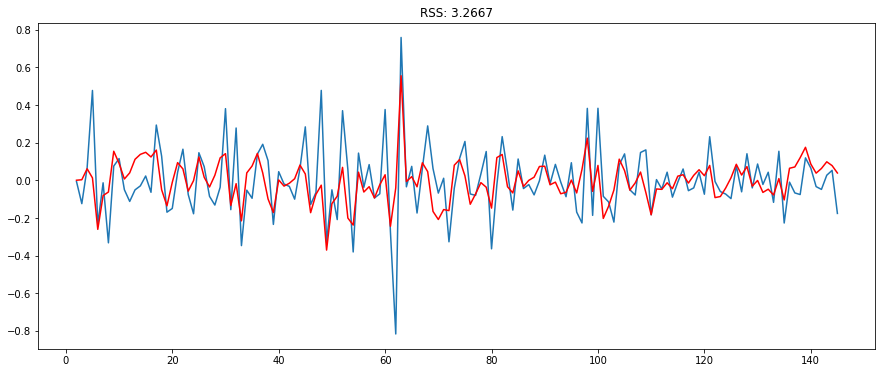

In [137]:
model=ARIMA(ts_log,order=(1,1,1))
result_ARIMA=model.fit()
print(result_ARIMA.summary())
plt.plot(ts_log_diff)
plt.plot(result_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((result_ARIMA.fittedvalues-ts_log_diff)**2))

### Convert to Original Scale

In [132]:
predictions_ARIMA_diff=pd.Series(result_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log=pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)



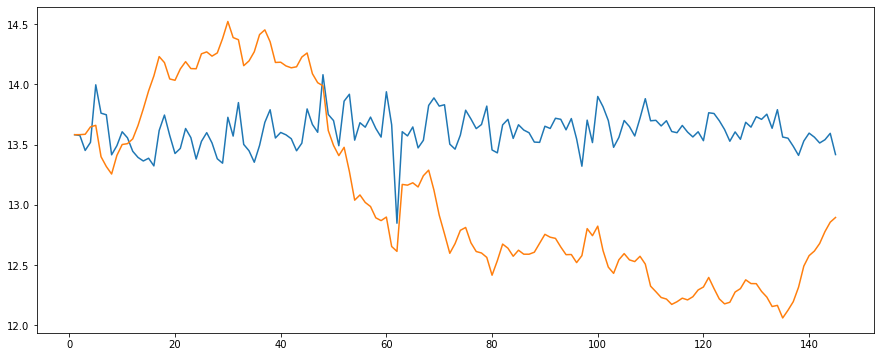

In [133]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 569597.1324')

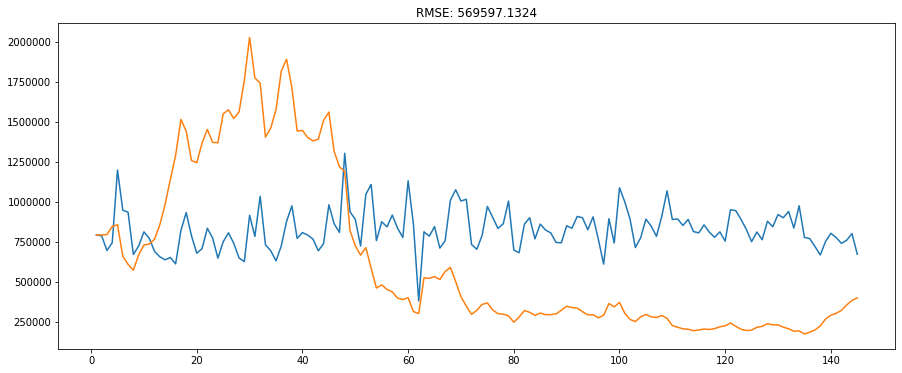

In [141]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [142]:
fc, se, conf =result_ARIMA.forecast(2,alpha=0.5)

In [143]:
fc

array([13.58820385, 13.63206984])

In [144]:
se

array([0.14802726, 0.15278401])

In [145]:
conf

array([[13.48836098, 13.68804671],
       [13.52901859, 13.73512108]])